In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from PIL import Image

Upload any image using the interface below. Or use the example `storefront.jpg` provided.

In [1]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving storefront.jpg to storefront.jpg
User uploaded file "storefront.jpg" with length 38797 bytes


(352, 536, 3)


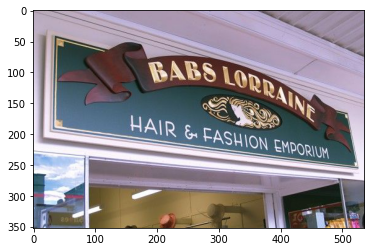

In [8]:
filename = next(iter(uploaded))
image_file = Image.open(filename)
img = np.asarray(image_file)
plt.imshow(img)
print(img.shape)

Set input points of the image below in the first line. These should be the points of the four corners of the original image ordered in counterclockwise starting from Q1 (top right point).

[[515 103]
 [ 33 103]
 [ 33 224]
 [515 224]]


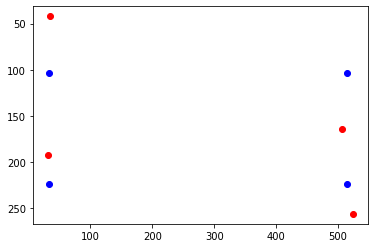

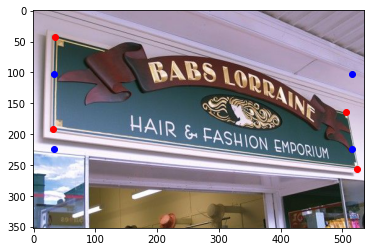

In [20]:
toprightpt = [506, 164]
topleftpt = [35, 42]
bottomleftpt = [32, 192]
bottomrightpt = [524, 256]

inpts = np.array([toprightpt, topleftpt, bottomleftpt, bottomrightpt]) # (x,y) points ordered in counterclockwise starting from Quadrant 1
# above are the points of the storefront.jpg example.

# Get Output Points based on Input points
def gen_outpts(input):
  yt = np.uint16((input[0][1] + input[1][1])/2)
  xr = np.uint16((input[0][0] + input[3][0])/2)
  yb = np.uint16((input[2][1] + input[3][1])/2)
  xl = np.uint16((input[1][0] + input[2][0])/2)
  return np.array([[xr,yt],[xl,yt],[xl,yb],[xr,yb]])

outpts = gen_outpts(inpts)
print(outpts)

# Plots points
plt.figure()
plt.gca().invert_yaxis()
#plt.imshow(img)
plt.plot(inpts[:,0], inpts[:,1], 'ro')
plt.plot(outpts[:,0],outpts[:,1],'bo')

plt.figure()
plt.imshow(img)
plt.plot(inpts[:,0], inpts[:,1], 'ro')
plt.plot(outpts[:,0],outpts[:,1],'bo')

In [21]:
# Build Homography
def buildA(inpt, outpt):
  x = inpt[0]
  y = inpt[1]
  x2 = outpt[0]
  y2 = outpt[1]
  A = np.array([[-1*x,-1*y,-1,0,0,0,x2*x,x2*y,x2],
                [0,0,0,-1*x,-1*y,-1,1*y2*x,1*y2*y,1*y2]])
  return A

def findHomography(inputs, outpts):
  A1 = buildA(inpts[0],outpts[0])
  A2 = buildA(inpts[1],outpts[1])
  A3 = buildA(inpts[2],outpts[2])
  A4 = buildA(inpts[3],outpts[3])
  Ad = np.vstack((A1,A2,A3,A4))
  #print(A1)
  u, s, vh = np.linalg.svd(Ad)
  Harr = vh[-1,:] # Use last row, not column
  H = np.matrix([[Harr[0],Harr[1],Harr[2]],[Harr[3],Harr[4],Harr[5]],[Harr[6],Harr[7],Harr[8]]])
  return H

H = findHomography(inpts,outpts)
iH = inv(H)
#H = np.matmul(H,iH)
print(H)

[[ 7.45473115e-03  3.55548243e-04  1.52209655e-01]
 [-4.19709249e-03  1.17810869e-02  9.88153251e-01]
 [-1.26763378e-05  6.00264353e-06  1.31630236e-02]]


In [22]:
# Ranges and Shape of Input
sz = img.shape
ys = range(sz[0])
xs = range(sz[1])
print(sz)

(352, 536, 3)


In [23]:
# Stores all Points in Image into Matrix
G = []
for i in xs:
    for j in ys:
      G.append([i,j,1])

G = np.matrix(G).T
print(G)

[[  0   0   0 ... 535 535 535]
 [  0   1   2 ... 349 350 351]
 [  1   1   1 ...   1   1   1]]


In [24]:
# Multiplies Points by Homography, then makes i*j assignments.

# IMPORTANT: JPEG images need to be uint8 arrays
outarr = np.zeros((sz[0],sz[1],sz[2]), dtype='uint8')

k = 0
zL = np.matmul(iH,G)
for i in xs:
  for j in ys:
    zl = zL[:,k]
    z2l = np.array([np.int16(zl[0,0]/zl[2,0]),np.int16(zl[1,0]/zl[2,0])])
    k = k + 1
    if (np.abs(z2l[1]) < sz[0] and np.abs(z2l[0]) < sz[1]): 
      outarr[j,i] = img[z2l[1],z2l[0]]
    else:
      outarr[j,i] = 0
  
outimg = Image.fromarray(outarr, mode='RGB')
print("Homography Applied")

Homography Applied


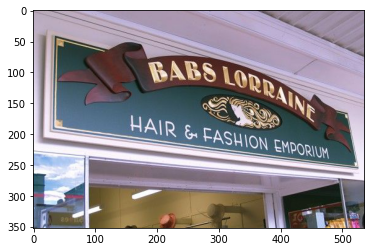

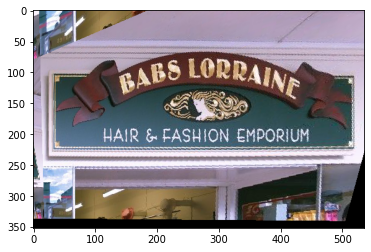

In [26]:
plt.figure()
plt.imshow(img)
plt.show()
plt.imshow(outimg)
plt.show()